# Human Facial Emotion/Expression Recognition & Classification
Carnegie Mellon University

24-787 Intro to AI & ML

## Acknowlegment
We, Sam, Nischal, Peter, Prakrit, and Atharva, would like to express sincere thanks to Prof. Amir Barati Farimani and the teaching assistant, Tong Lin, for informative and supportive assist throughout this project.

## Work Log

#### workers: ['Sam', 'Nischal', 'Peter', 'Prakrit', 'Atharva']
num_workers = 5
________________________________________________________________________________________________________________
Before 11.23.2022
Update (by Sam):
1. Received a mini version of AffectNet dataset from the owner.
2. Extracted train dataset's image file names and expressin annotation (exp) file names and saved them as a numpy file (.npy) to prevent extracting them every time running these scripts. 
3. Created a class for creating custom datasets.
4. Created dataloaders for train and validation datasets so that bathchlization is possible during training our basline CNN model and prevents from having RAM over-usage.

11.23.2022
Update (by Nischal):
1. Created training and validation loop for baseline neural network. @Sam, I need your help in running this notebook. I still haven't set it up on Colab. I should be able to figure it out by the end of this week.

11.24.2022
Update (by Sam):
1. Made a few minor modifications:
     - Printed size of dataloaders.
     - Added CUDA Activation
          - device = torch.device('cuda')
     - Converted x_batch's dtype from torch.unit8 to torch.float
     - Converted x_val's dtype from torch.unit8 to torch.float
Next task 1: cuda ('gpu') activation of the CNN baseline model ("emotion_model") & x_batch, y_batch, x_val, y_val -- COMPLETE
Next task 2: Transfer learning -- INCOMPLETE

12.01.2022
Update (by Sam):
1. Made modifications to our codes here and there.
     - Converted the baseline CNN model and torch tensors to CUDA for a fast model training.
     - Converted torch tensors from gpu to cpu for calculating loss during training.
     - Edited the codes to load train_exp_annot.npy & train_image_names.npy after saving them.
Next task 1: Transfer learning -- In Progress

12.03.2022:
Update (by Nischal):
1. Implemeted transfer learning using resnet 18 pretrained weights(both finetunr and frozen methods)
2. Created a function for training and testing instead of rewriting the code
3. Added a plot for train and validation accuracy vs epoch

12.04.2022 
Update (by Sam):
1. Created a new validation data subset using a portion of training data subset. 
     - Managed to keep the new validation data not existing in the training data subset.
     - It seems that original validation dataset's labels are biased. 
          - The way that the original validation dataset was labeled might had been not in line with how the original train dataset was labeled.
          - There was only one annotator for AffectNet dataset. This could be one of the reasons for the bias?
2. Tested the accuracy on validation dataset using our baseline CNN model & Transferred Model.
3. Tested the accuracy on test dataset using our baseline CNN model & Transferred Model.

12.05.2022 
Update (by Sam):
1. Previously we decided to create validation and test datasets using Train Test Val Split (80% 10% 10%) -- Agreed w/ Sam & Nischal & Prakrit
     - Split the Train dataset into Train, Test, and Validation datasets (80% 10% 10% split).

12.06.2022
Update (by Nischal & Prakrit & Sam):
1. Impemented Face Detection and Prediction of its emotion.
     - Still need to shapens it that it detects better.
2. Added scripts at the end to predict the emotion of a given input image and compare it to the ground truth emotion.

Update (by Sam & Nischal):
1. Detected errors in reshaping lively detected faces from (244,244,3) to (3,244,244). Previously, we used "reshape(3,244,244)", but we figured that it returns a non-facial image. We relaced this with "moveaxis(image, -1, 0)" which place the last channel as the first channel and still returns a face image.

Update (by Peter):
1. Ran the training of our baseline CNN for the whole dataset and saved the best model as a ".pt" file.

12.07.2022
Update (by Sam):
1. Created a confusion matrix for our basline CNN model for prediction on our test dataset.

Update (by Peter):
1. Counted the number of images per class in Train, Test, Validation datasets.
2. Create a normalized confusion matrix.
3. Calculated precision, recall, and f-1 scores.

Update (by Sam):
1. Corrected errors in the bar plot's image count per class for Train, Test, Validation datasets. 11 emotions were counted per dataset, but corrected it to count 8 emotions per dataset.
2. Corrected the confusion matrix and the normalized confusion matrix so that all the values match between these confusion matrices and the bar plots.

12.14.2022
Update (by Sam):
1. Added a script to lively detect faces and predict their emotions in screen mirroring.


## READ.ME - Prerequesites for running this code:
1. Create a folder named "dataset" in your current working directory (where this Jupyter Notebook is saved). 
2. Then extract the OneDrive AffectNet zip file inside the "dataset" folder. 
3. You will see 2 files in the "dataset" folder: "train_set.tar" and "val_set.tar" 
4. Save "train_exp_annot.npy" and "train_img_names.npy" in the "dataset" folder (This will save your time from extracting training dataset's 1150604 expression annotation file names and 287651 image file names).

## Import/Install Necessary Libraries and Modules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit Learn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# PyTorch
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms as T
from torchvision.io import read_image

# TensorFlow & Keras
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import image
from keras.models import  load_model

# OpenCV
import cv2

import warnings
warnings.filterwarnings("ignore")

from PIL import Image
from PIL import ImageGrab

from tqdm import tqdm

import tarfile

# ! pip install natsort
from natsort import natsorted

# ! pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CUDA Check

In [2]:
# display your current working directory (cwd)
print(f"Current directory: {os.getcwd()}")

# check pytorch cuda and use cuda if possible
device = torch.device('cuda')
print('*' * 50)
if torch.cuda.is_available():  
    print('CUDA is found: %s.'%torch.cuda.get_device_name(0))
else:
    warnings.warn('CUDA not found! Training may be slow......')

Current directory: c:\Users\whdqk\OneDrive\Desktop\Academic\Fall 2022\24787 Intro to ML for Engineers\Projects
**************************************************
CUDA is found: NVIDIA GeForce GTX 1650 with Max-Q Design.


## Extract Train Dataset
Both Train Dataset is in the format of tar archive file.
Let's extract them and save them as "extracted_train_tar".

File Counts:
1. Train dataset's image files: 287651
2. Train dataset's annotation files: 287651*4 = 1150604

In [3]:
# Extract train set tar file (train_set.tar)
if os.path.exists("dataset/extracted_train_tar") != True: 

    #declare filename
    train_name = "dataset/train_set.tar"

    #open file in write mode
    train_tar= tarfile.open(train_name,"r")
    
    # extract all contents
    file = train_tar.extractall("dataset/extracted_train_tar")

    #close file
    file_obj.close()

## Custom Dataset
### Will use expression annotation (exp.npy) files only for the emotion classification part.
### 0: Neutral, 1: Happiness, 2: Sadness, 3: Surprise, 4: Fear, 5: Disgust, 6: Anger, 7: Contempt

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_file_names, img_dir, annotations, annot_dir, transform=None, target_transform=None):
        self.img_names = img_file_names
        self.img_dir = img_dir
        self.annotations = annotations
        self.annot_dir = annot_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = self.img_dir + "/" + self.img_names[idx]
        image = read_image(img_path)
        label_path = self.annot_dir + "/" + self.annotations[idx]
        label = np.load(label_path)
        label = int(label) # change dtype from U1 to int
        label_file_name = self.annotations[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, label_file_name

### -Importing train data (images and labels (annotations))

In [5]:
## Training dataset

# training images directory (path)
train_img_dir = "dataset/extracted_train_tar/train_set/images"

# training annotations directory (path)
train_annot_dir = "dataset/extracted_train_tar/train_set/annotations"

# training image file names (sort in numberical order)
if os.path.exists("dataset/train_img_names.npy") != True:
    # training image file names
    train_img_names = natsorted(os.listdir("dataset/extracted_train_tar/train_set/images"))
    train_img_names = np.save("dataset/train_img_names.npy", train_img_names, allow_pickle=True)
    # extract train_img_names.npy (already sorted in numerical order)
    train_img_names = np.load("dataset/train_img_names.npy")
else:
    # extract train_img_names.npy (already sorted in numerical order)
    train_img_names = np.load("dataset/train_img_names.npy")

# training "expression" annotations (sort in numerical order!)
if os.path.exists("dataset/train_exp_annot.npy") != True:
    # training annotation file names
    train_annotations = natsorted(os.listdir("dataset/extracted_train_tar/train_set/annotations"))
    train_exp_annot = np.array([])
    for annot in train_annotations:
        if 'exp' in annot:
            train_exp_annot = np.append(train_exp_annot, annot)
    train_exp_annot = np.save("dataset/train_exp_annot.npy", train_exp_annot, allow_pickle=True) # "expression" annotation file names
    # extract train_exp.npy (already sorted in numerical order)
    train_exp_annot = np.load("dataset/train_exp_annot.npy") # "expression" annotation file names
else:
    # extract train_exp.npy (already sorted in numerical order)
    train_exp_annot = np.load("dataset/train_exp_annot.npy") # "expression" annotation file names

In [6]:
test_img_dir = train_img_dir
test_annot_dir = train_annot_dir

val_img_dir = train_img_dir
val_annot_dir = train_annot_dir

## -Train Test Validation Split - 80% 10% 10%
Initially, the given AffectNet dataset has training dataset. Thus, we split the original training dataset into training dataset, test dataset, and validation dataset.

In [7]:
np.random.seed(5)
np.random.shuffle(train_img_names)
np.random.seed(5)
np.random.shuffle(train_exp_annot)

torch.manual_seed(0)
train_img_names, test_img_names, val_img_names = torch.utils.data.random_split(train_img_names, [0.8, 0.1, 0.1])
torch.manual_seed(0)
train_exp_annot, test_exp_annot, val_exp_annot = torch.utils.data.random_split(train_exp_annot, [0.8, 0.1, 0.1])

In [8]:
print(f"The number of data in the Train Dataset after Train Test Val split: {len(train_exp_annot)}")
print(f"The number of data in the Test Dataset after Train Test Val split: {len(test_exp_annot)}")
print(f"The number of data in the Validation Dataset after Train Test Val split: {len(val_exp_annot)}")


The number of data in the Train Dataset after Train Test Val split: 230121
The number of data in the Test Dataset after Train Test Val split: 28765
The number of data in the Validation Dataset after Train Test Val split: 28765


In [ ]:
import array as arr
from matplotlib.pyplot import figure


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = 'center', fontsize=8)
        
def drawCounts(x, y):
    emotions = ('neutral', 'happiness', 'sad', 'suprise', 'fear', 'disgust', 'anger', 'contempt')
    test = []
    
    for i in range(len(x)):
        n = np.load("dataset/extracted_train_tar/train_set/annotations/" + x[i]).item()
        test.append(n)
        
    test = np.array(test)
    unique, counts = np.unique(test, return_counts=True)
    dict(zip(unique, counts))
    print(unique)
    print(counts)

    for i in range(len(unique)):
        plt.bar(emotions[i],counts[i])
        addlabels(unique, counts)
        
    plt.xlabel("emotion labels")
    plt.ylabel("No. of images")
    plt.title("number of images per class in {}".format(y))
    plt.xticks(rotation = 90)
    plt.savefig("number of images per class in {}.png".format(y))
    plt.show()

drawCounts(train_exp_annot, "training set")
drawCounts(test_exp_annot, "test Set")
drawCounts(val_exp_annot, "validation Set")


### - Custom Dataset

#### - Custom Training Dataset

In [10]:
# Custom Training Dataset
train_Dataset=CustomImageDataset(train_img_names, train_img_dir, train_exp_annot, train_annot_dir)

In [11]:
train_img_names[:]

array(['136972.jpg', '126617.jpg', '81044.jpg', ..., '181697.jpg',
       '115739.jpg', '366705.jpg'], dtype='<U10')

tensor([[[ 12,  11,  10,  ...,  43,  33,  45],
         [ 12,  12,  10,  ...,  43,  34,  47],
         [ 12,  12,  10,  ...,  42,  37,  50],
         ...,
         [ 38,  38,  39,  ...,  56,  53,  52],
         [ 37,  38,  38,  ...,  56,  52,  54],
         [ 37,  38,  38,  ...,  44,  91, 142]],

        [[ 12,  11,  12,  ...,  29,  22,  34],
         [ 12,  12,  12,  ...,  29,  23,  36],
         [ 12,  12,  12,  ...,  31,  26,  39],
         ...,
         [ 71,  71,  72,  ...,  93,  87,  86],
         [ 70,  71,  71,  ..., 102,  94,  92],
         [ 70,  71,  71,  ...,  93, 134, 183]],

        [[ 12,  11,  11,  ...,  28,  20,  32],
         [ 12,  12,  11,  ...,  28,  21,  34],
         [ 12,  12,  11,  ...,  29,  24,  37],
         ...,
         [114, 114, 115,  ..., 135, 132, 131],
         [113, 114, 114,  ..., 152, 144, 141],
         [113, 114, 114,  ..., 149, 187, 235]]], dtype=torch.uint8)
2
281091_exp.npy


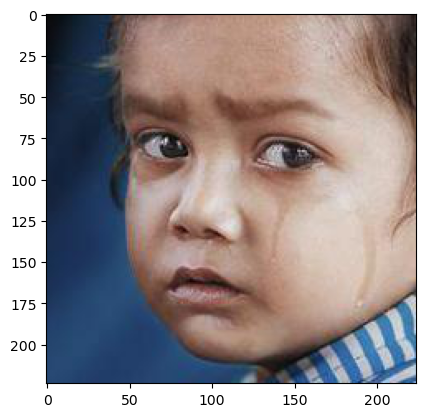

In [12]:
## Example

img_idx = 1805 # image index (starting from 0)
print(train_Dataset[img_idx][0]) # image's tensor
print(train_Dataset[img_idx][1]) # image's expression value
print(train_Dataset[img_idx][2]) # image's expression annotation file name

# image
transform = T.ToPILImage()
img = transform(train_Dataset[img_idx][0])
plt.imshow(img)

#### - Custom Test Dataset

In [13]:
test_Dataset=CustomImageDataset(test_img_names, test_img_dir, test_exp_annot, test_annot_dir)

tensor([[[ 47,  47,  47,  ...,  30,  31,  27],
         [ 44,  44,  44,  ...,  29,  30,  27],
         [ 44,  44,  44,  ...,  27,  28,  26],
         ...,
         [ 86,  89,  92,  ..., 101,  97,  87],
         [ 94,  97,  99,  ..., 101,  98,  87],
         [102, 104, 105,  ..., 104, 104,  93]],

        [[ 37,  37,  37,  ...,  25,  26,  23],
         [ 34,  34,  34,  ...,  24,  25,  23],
         [ 34,  34,  34,  ...,  22,  23,  22],
         ...,
         [ 92,  95,  97,  ..., 105,  98,  88],
         [100, 103, 105,  ..., 105,  99,  88],
         [108, 110, 111,  ..., 108, 105,  94]],

        [[ 25,  25,  25,  ...,  21,  23,  20],
         [ 22,  22,  22,  ...,  20,  22,  20],
         [ 22,  22,  22,  ...,  18,  20,  19],
         ...,
         [ 66,  69,  74,  ..., 108, 102,  90],
         [ 74,  77,  79,  ..., 108, 101,  90],
         [ 80,  82,  85,  ..., 111, 107,  96]]], dtype=torch.uint8)
7
110080_exp.npy


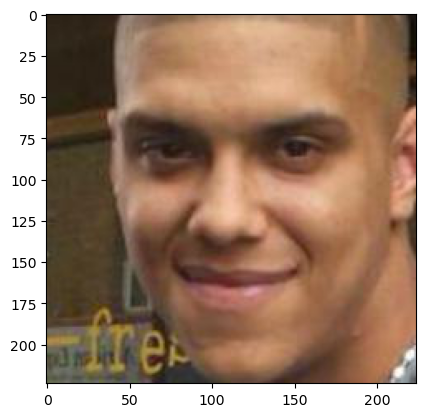

In [14]:
## Example

img_idx = 8888 # image index (starting from 0)
print(test_Dataset[img_idx][0]) # image's tensor
print(test_Dataset[img_idx][1]) # image's expression value
print(test_Dataset[img_idx][2]) # image's expression annotation file name

# image
transform = T.ToPILImage()
img = transform(test_Dataset[img_idx][0])
plt.imshow(img)

#### - Custom Validation Dataset

In [15]:
val_Dataset=CustomImageDataset(val_img_names, val_img_dir, val_exp_annot, val_annot_dir)

tensor([[[ 2, 13,  9,  ..., 30,  0, 10],
         [ 2, 11,  7,  ..., 15, 11,  3],
         [ 2,  7,  4,  ...,  4, 27,  2],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 2, 13,  9,  ..., 30,  0, 10],
         [ 2, 11,  7,  ..., 15, 11,  3],
         [ 2,  7,  4,  ...,  4, 27,  2],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 2, 13,  9,  ..., 30,  0, 10],
         [ 2, 11,  7,  ..., 15, 11,  3],
         [ 2,  7,  4,  ...,  4, 27,  2],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]]], dtype=torch.uint8)
5
42022_exp.npy


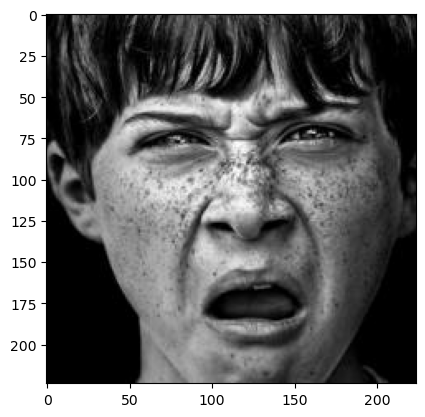

In [16]:
## Example

img_idx = 0 # image index (starting from 0)
print(val_Dataset[img_idx][0]) # image's tensor
print(val_Dataset[img_idx][1]) # image's expression value
print(val_Dataset[img_idx][2]) # image's expression annotation file name

# image
transform = T.ToPILImage()
img = transform(val_Dataset[img_idx][0])
plt.imshow(img)



## DataLoader

### - Validation Dataloader

In [17]:
val_batch = 50 # the number of datasamples per batch
val_dataloader = DataLoader(val_Dataset, batch_size=val_batch, shuffle=True)

In [18]:
val_features, val_labels, _ = next(iter(val_dataloader))
print(val_features.size()) # feature batch size
print(val_labels.size()) # label batch size

torch.Size([50, 3, 224, 224])
torch.Size([50])


In [19]:
# print fisrt sample from one batch
print(val_features[0])
print(val_labels[0])

tensor([[[ 14,  16,  18,  ..., 203, 189, 186],
         [ 13,  15,  18,  ..., 200, 197, 185],
         [ 12,  14,  17,  ..., 197, 204, 187],
         ...,
         [129, 126, 128,  ..., 162, 160, 163],
         [136, 134, 137,  ..., 163, 162, 165],
         [144, 143, 146,  ..., 165, 164, 165]],

        [[  1,   3,   5,  ..., 196, 183, 183],
         [  0,   2,   5,  ..., 193, 191, 182],
         [  0,   1,   4,  ..., 190, 198, 184],
         ...,
         [ 78,  75,  77,  ..., 103,  99, 102],
         [ 84,  83,  86,  ..., 104, 101, 101],
         [ 92,  92,  95,  ..., 106, 103, 101]],

        [[  0,   0,   0,  ..., 177, 167, 168],
         [  0,   0,   0,  ..., 174, 175, 167],
         [  0,   0,   0,  ..., 171, 182, 167],
         ...,
         [ 51,  46,  48,  ...,  73,  70,  73],
         [ 60,  56,  57,  ...,  74,  72,  73],
         [ 68,  65,  68,  ...,  76,  74,  73]]], dtype=torch.uint8)
tensor(1)


### - Train Dataloader

In [20]:
train_batch = 50 # the number of datasamples per batch
train_dataloader = DataLoader(train_Dataset, batch_size=train_batch, shuffle=True)

In [21]:
train_features, train_labels, _ = next(iter(train_dataloader))
print(train_features.size()) # feature batch size
print(train_labels.size()) # label batch size

torch.Size([50, 3, 224, 224])
torch.Size([50])


In [22]:
# print fisrt sample from one batch
print(train_features[0])
print(train_labels[0])

tensor([[[218, 222, 232,  ..., 178, 199, 213],
         [220, 223, 231,  ..., 188, 198, 202],
         [223, 225, 231,  ..., 192, 182, 170],
         ...,
         [201, 197, 192,  ..., 192, 195, 178],
         [199, 198, 195,  ..., 175, 183, 172],
         [184, 190, 196,  ..., 176, 185, 178]],

        [[224, 228, 238,  ..., 197, 219, 231],
         [226, 229, 237,  ..., 207, 217, 221],
         [232, 231, 237,  ..., 209, 200, 188],
         ...,
         [255, 252, 248,  ..., 251, 251, 233],
         [250, 251, 250,  ..., 252, 255, 245],
         [234, 241, 249,  ..., 255, 255, 255]],

        [[224, 228, 238,  ..., 115, 132, 145],
         [226, 229, 237,  ..., 128, 136, 139],
         [231, 231, 237,  ..., 139, 126, 114],
         ...,
         [250, 247, 245,  ..., 249, 250, 230],
         [243, 243, 245,  ..., 246, 251, 238],
         [225, 234, 243,  ..., 253, 255, 251]]], dtype=torch.uint8)
tensor(1)


### - Test Dataloader

In [23]:
test_batch = 200 # the number of datasamples per batch
test_dataloader = DataLoader(test_Dataset, batch_size=test_batch, shuffle=True)

In [24]:
test_features, test_labels, _ = next(iter(test_dataloader))
print(test_features.size()) # feature batch size
print(test_labels.size()) # label batch size

torch.Size([200, 3, 224, 224])
torch.Size([200])


In [25]:
# print fisrt sample from one batch
print(test_features[0])
print(test_labels[0])

tensor([[[  0,   0,   0,  ...,  23,  24,   0],
         [  0,   0,   0,  ...,   6,  22,  21],
         [  0,   0,   0,  ...,   0,  11,  30],
         ...,
         [170, 172, 156,  ...,   0,   0,   0],
         [166, 175, 127,  ...,   0,   0,   0],
         [154, 177, 107,  ...,   0,   0,   0]],

        [[  0,   0,   0,  ...,  37,  38,   4],
         [  0,   0,   0,  ...,  20,  36,  35],
         [  0,   0,   0,  ...,  12,  25,  44],
         ...,
         [128, 130, 115,  ...,   2,   4,   5],
         [124, 133,  85,  ...,   2,   4,   5],
         [112, 135,  65,  ...,   2,   5,   5]],

        [[  0,   0,   0,  ...,  38,  39,   7],
         [  0,   0,   0,  ...,  21,  37,  38],
         [  0,   0,   0,  ...,  15,  28,  47],
         ...,
         [112, 114,  97,  ...,   1,   0,   1],
         [108, 117,  69,  ...,   1,   0,   1],
         [ 96, 119,  49,  ...,   1,   1,   1]]], dtype=torch.uint8)
tensor(2)


# CNN Model

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class EmotionClassifier(nn.Module):
    def __init__(self, num_emotions=8):
        super(EmotionClassifier, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2) # default value of stride is kernel size
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(in_features=14 * 14 * 24, out_features=num_emotions)

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu(output)
        output = self.pool(output)
        # output = self.pool(F.relu(self.conv1)) Replace with shorter alternative
        output = self.conv2(output)
        output = self.relu(output)
        output = self.pool(output)
        # output = self.pool(F.relu(self.conv2))
        output = self.conv3(output)
        output = self.relu(output)
        output = self.pool(output)
        # output = self.pool(F.relu(self.conv3))
        output = self.conv4(output)
        output = self.relu(output)
        output = self.pool(output)
        # output = self.pool(F.relu(self.conv4))
        output = self.conv5(output)
        output = self.relu(output)

        output = output.view(-1, 14 * 14 * 24)
        output = self.fc(output)
        return output

### - Check if there was a data leakage between the train dataset, test dataset, and validation dataset.

In [ ]:
trainlist = []; testlist=[]; vallist=[]
train_dataloader = DataLoader(train_Dataset, batch_size=1, pin_memory=False, shuffle = False)
test_dataloader = DataLoader(test_Dataset, batch_size=1, pin_memory=False, shuffle = False)
val_dataloader = DataLoader(val_Dataset, batch_size=1, pin_memory=False, shuffle = False)

for x, y, annot in tqdm(train_dataloader):
    trainlist.append(x)
for x, y, annot in tqdm(test_dataloader):
    testlist.append(x)
for x, y, annot in tqdm(val_dataloader):
    vallist.append(x)

trainlist = set(trainlist)
testlist = set(testlist)
vallist = set(vallist)

print(f"The number of data leaked between Train and Test datasets during train test validation split: {len(trainlist & testlist)}") # the number of common images
print(f"The number of data leaked between Train and Validation datasets during train test validation split: {len(trainlist & vallist)}") # the number of common images
print(f"The number of data leaked between Test and Validation datasets during train test validation split: {len(vallist & testlist)}") # the number of common images


## - Model Training

In [66]:
# Emotion classifier model
num_emotions = 8
emotion_model = EmotionClassifier().to(device)
print(emotion_model)

EmotionClassifier(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=4704, out_features=8, bias=True)
)


In [ ]:
# Set learning rate, batch size and num of epochs
lr = 0.0005 # learning rate
batch_size = 64 # the number of data samples
n_epoch = 50 # epochs

# define loss function as cross entropy loss
loss_function = nn.CrossEntropyLoss()
# Load the data using dataloader
train_dataloader = DataLoader(train_Dataset, batch_size=batch_size, pin_memory=True, shuffle = False) # set to false since data is already shuffled
val_dataloader = DataLoader(val_Dataset, batch_size=batch_size, pin_memory=True, shuffle = False) # set to false since data is already shuffled
# create Adam optimizer
optimizer = torch.optim.Adam(emotion_model.parameters(), lr = lr)

# Initialize some variables
loss_epoch = []
accuracy_epoch = []
val_loss_epoch = []
val_accuracy_epoch = []
current_best_accuracy = 0.0

# TRAINING
for epoch in range(n_epoch):
  print(f"epoch: {epoch}")

  # TRAINING BY FITTING THE MODEL TO THE TRAIN IMAGE DATA
  batch_loss = []
  batch_accuracy = []
  i = 0
  for x_batch, y_batch, _ in tqdm(train_dataloader):
    x_batch = x_batch.type(torch.float) # switch the datatype to float
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    # Calculate output with current weights
    prediction_scores = emotion_model(x_batch)
    # Caluclate the loss of the current outputs using the loss_func defined earlier
    loss = loss_function(prediction_scores, y_batch)
    # Zero out the parameter gradients
    optimizer.zero_grad()
    # Perform backprop to calculate the gradients
    loss.backward()
    # Update the weights
    optimizer.step()
    # Append batch loss and accruracy for plotting
    batch_loss.append(loss.detach())
    # Identify the output with the highest score
    prediction = torch.argmax(prediction_scores.detach(),dim=1)
    batch_accuracy.append(torch.mean((prediction==y_batch).float()))
    # Check training accuracy at every certain batches
    if i == len(train_dataloader)//2 and i != 0:
      print(f"Training Accuracy for {len(train_dataloader)//2}th batch: {batch_accuracy[-1]*100}%")
    i = i+1

  # TRAINING BY FITTING THE MODEL TO THE VALIDATION IMAGE DATA
  batch_loss_val = []
  batch_accuracy_val = []
  i = 0
  for x_val, y_val,_ in tqdm(val_dataloader):
    x_val = x_val.type(torch.float) # switch the datatype to float
    x_val = x_val.to(device)
    y_val = y_val.to(device)
    # Calculate output with current weights
    prediction_scores = emotion_model(x_val)
    # Caluclate the loss of the current outputs using the loss_func defined earlier
    loss = loss_function(prediction_scores, y_val)
    # Append batch loss and accruracy for plotting
    batch_loss_val.append(loss.detach())
    # Identify the output with the highest score
    prediction = torch.argmax(prediction_scores.detach(),dim=1)
    # print(prediction, y_val, prediction==y_val, torch.mean((prediction==y_val).float())) #######################
    batch_accuracy_val.append(torch.mean((prediction == y_val).float())) 
    # Check validation accuracy at every certain batches
    if i == len(val_dataloader)//2 and i != 0:
      print(f"validation Accuracy for {len(val_dataloader)//2}th batch: {batch_accuracy_val[-1]*100}%")
    i = i+1

  # Save the trained model
  batch_loss = [loss.item() for loss in batch_loss]
  batch_loss_val = [loss.item() for loss in batch_loss_val]
  batch_accuracy = [loss.item() for loss in batch_accuracy]
  batch_accuracy_val = [loss.item() for loss in batch_accuracy_val]

  loss_epoch.append(np.mean(batch_loss))
  val_loss_epoch.append(np.mean(batch_loss_val))
  accuracy_epoch.append(np.mean(batch_accuracy))
  val_accuracy_epoch.append(np.mean(batch_accuracy_val))

  print("\n")
  print(f"Epoch = {epoch}, train loss = {loss_epoch[-1]}, validate loss = {val_loss_epoch[-1]}")
  print(f"Epoch = {epoch}, train accuracy = {accuracy_epoch[-1]}, validate accuracy = {val_accuracy_epoch[-1]}")

  if val_accuracy_epoch[-1] > current_best_accuracy:
    torch.save(emotion_model.state_dict(), 'current_best_model.pt')
    current_best_accuracy = val_accuracy_epoch[-1]
    print(f"Best accuracy so far. Current validation accurcy={current_best_accuracy*100}%. Saving as a model..")
    print("\n")

In [ ]:
# Let's plot train loss & validation loss and train accuracy & validation accuracy of our baseline model.
fig,axes = plt.subplots(nrows=1,ncols=2)
axes[0].plot(range(n_epoch),loss_epoch,label='Train Loss')
axes[0].plot(range(n_epoch),val_loss_epoch,label='Validate Loss')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(range(n_epoch),accuracy_epoch,label='Train Accuracy')
axes[1].plot(range(n_epoch),val_accuracy_epoch,label='Validate Accuracy')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

### - Accuracy of the Test Dataset with Non-Trained Model.

In [ ]:
batch_size = 64 # batch size
test_dataloader = DataLoader(test_Dataset, batch_size=batch_size, pin_memory=True, shuffle = False) # test dataloader
emotion_model_notTrained = EmotionClassifier().to(device)
batch_accuracy = []
i = 0
for x_test, y_test,_ in test_dataloader:
    x_test = x_test.type(torch.float) # switch the datatype to float
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    prediction_scores = emotion_model_notTrained(x_test) # prediction scores
    prediction = torch.argmax(prediction_scores.detach(),dim=1) # prediction
    batch_accuracy.append(torch.mean((prediction==y_test).float())) # accuracy
    print(f"Accuracy at {i}th batch: {batch_accuracy[-1]*100}%")
    i += 1

### - Loading the Trained Emotion Classifier Model

In [7]:
# Load the trained model
trained_emotion_model = EmotionClassifier().to(device)
trained_emotion_model.load_state_dict(torch.load('current_best_model.pt'), strict=False)
trained_emotion_model

EmotionClassifier(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=4704, out_features=8, bias=True)
)

### - Accuracy of the Test Dataset with Trained Model.

In [30]:
batch_size = 64 # batch size
test_dataloader = DataLoader(test_Dataset, batch_size=batch_size, pin_memory=False, shuffle = False) # test dataloader
batch_accuracy = []
annot_predicted = torch.tensor([])
annot_ground_truth = torch.tensor([])
i = 0
for x_test, y_test,_ in test_dataloader:
    x_test = x_test.type(torch.float) # switch the datatype to float
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    prediction_scores = trained_emotion_model(x_test) # prediction scores
    prediction = torch.argmax(prediction_scores.detach(),dim=1) # prediction
    batch_accuracy.append(torch.mean((prediction==y_test).float())) # accuracy
    print(f"Accuracy at {i}th batch: {batch_accuracy[-1]*100}%")

    # for plotting confusion matrix
    annot_ground_truth = torch.cat((annot_ground_truth, y_test.cpu()), dim=0) # ground truth annotations
    annot_predicted = torch.cat((annot_predicted, prediction.cpu()), dim=0) # predicted annotations

    i += 1



Accuracy at 0th batch: 62.5%
Accuracy at 1th batch: 75.0%
Accuracy at 2th batch: 62.5%
Accuracy at 3th batch: 67.1875%
Accuracy at 4th batch: 81.25%
Accuracy at 5th batch: 71.875%
Accuracy at 6th batch: 68.75%
Accuracy at 7th batch: 65.625%
Accuracy at 8th batch: 67.1875%
Accuracy at 9th batch: 64.0625%
Accuracy at 10th batch: 67.1875%
Accuracy at 11th batch: 68.75%
Accuracy at 12th batch: 73.4375%
Accuracy at 13th batch: 68.75%
Accuracy at 14th batch: 76.5625%
Accuracy at 15th batch: 71.875%
Accuracy at 16th batch: 67.1875%
Accuracy at 17th batch: 75.0%
Accuracy at 18th batch: 68.75%
Accuracy at 19th batch: 57.8125%
Accuracy at 20th batch: 82.8125%
Accuracy at 21th batch: 71.875%
Accuracy at 22th batch: 67.1875%
Accuracy at 23th batch: 71.875%
Accuracy at 24th batch: 64.0625%
Accuracy at 25th batch: 75.0%
Accuracy at 26th batch: 67.1875%
Accuracy at 27th batch: 73.4375%
Accuracy at 28th batch: 68.75%
Accuracy at 29th batch: 82.8125%
Accuracy at 30th batch: 79.6875%
Accuracy at 31th ba

### - Confusion Matrix of Prediction on Test Dataset Using Our Trained Basline Model

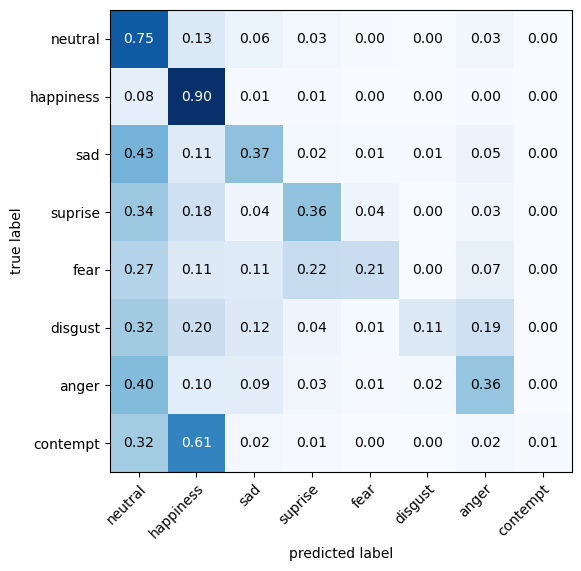

In [31]:
# annotations list
emotions = ('neutral', 'happiness', 'sad', 'suprise', 'fear', 'disgust', 'anger', 'contempt')

# Confusion Matrix displaying ratio
confmat= confusion_matrix(annot_ground_truth, annot_predicted)

fig, ax = plot_confusion_matrix(conf_mat=confmat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions,
                                figsize = (11,6))
fig.show()

plt.savefig('confusion_matrix_ratio.png') # save the confusion matrix figure


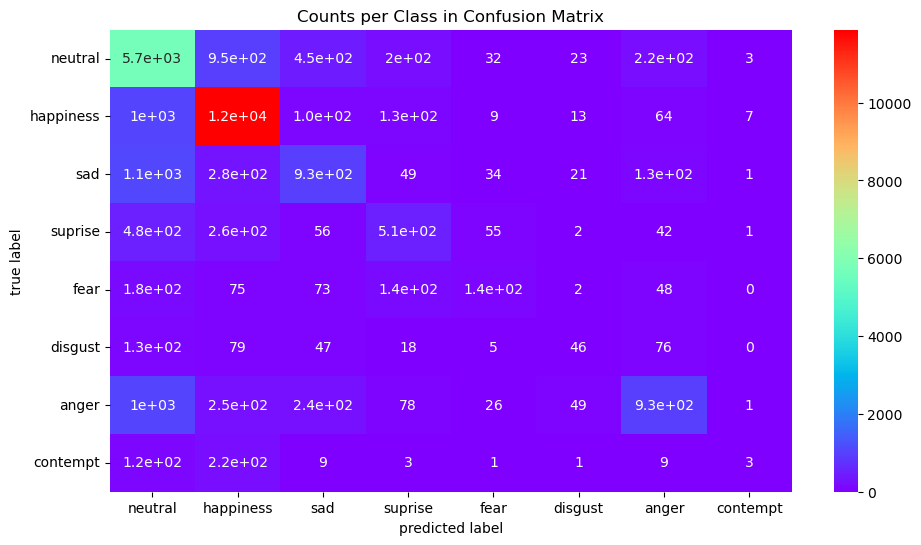

In [32]:
# annotations list
emotions = ('neutral', 'happiness', 'sad', 'suprise', 'fear', 'disgust', 'anger', 'contempt')

# Confusion Matrix displaying Counts
confmat = confusion_matrix(annot_ground_truth, annot_predicted) # confusion matrix
confmat_df = pd.DataFrame(confmat/np.sum(confmat) *len(test_Dataset), index = [i for i in emotions], columns = [i for i in emotions]) # conf data frame
plt.figure(figsize = (11,6))
sns.heatmap(confmat_df, annot=True, cmap='rainbow')
plt.title("Counts per Class in Confusion Matrix")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.savefig('confusion_matrix_count.png') # save the confusion matrix figure

### - Precision, Recall, & F1-Score

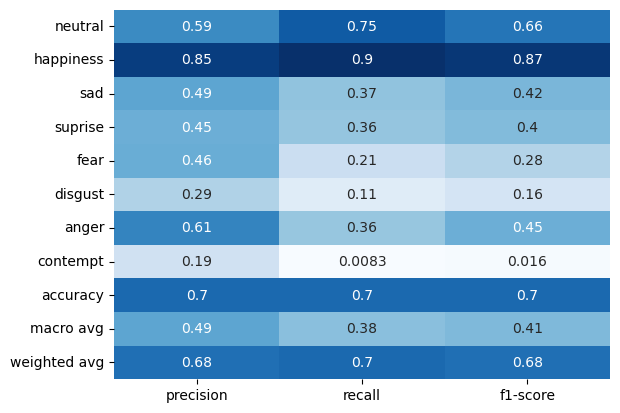

In [33]:
clf_report = classification_report(annot_ground_truth, annot_predicted, target_names=emotions, output_dict = True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, cbar=0, annot=True, cmap="Blues")
plt.figsize = (11,6)
plt.savefig("precision,recall,f-1score.png")

## Testing Accuracy on Pre-Trained Bechmark Model - ResNet18 
(for Comparison to Our Basline Model)

### Importing pretrained models and learning rate scheduler

In [ ]:
from torchvision import models
from torch.optim import lr_scheduler
import copy
from matplotlib import pyplot as plt

In [ ]:
def model_train(model, lr, batch_size,n_epoch,model_name):
  # Set learning rate, batch size and num of epochs
  lr = lr # learning rate
  batch_size = batch_size # the number of data samples
  n_epoch = n_epoch # epochs

  # define loss function as cross entropy loss
  loss_function = nn.CrossEntropyLoss()
  # Load the data using dataloader
  train_dataloader = DataLoader(train_Dataset, batch_size=batch_size, pin_memory=False, shuffle = False) # set to false since data is already shuffled
  val_dataloader = DataLoader(val_Dataset, batch_size=batch_size, pin_memory=False, shuffle = False) # set to false since data is already shuffled
  # create Adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  # Initialize some variables
  loss_epoch = []
  accuracy_epoch = []
  val_loss_epoch = []
  val_accuracy_epoch = []
  current_best_accuracy = 0.0

  # TRAINING
  for epoch in range(n_epoch):
    print(f"epoch: {epoch}")

    # TRAINING BY FITTING THE MODEL TO THE TRAIN IMAGE DATA
    batch_loss = []
    batch_accuracy = []
    i = 0
    for x_batch, y_batch, _ in tqdm(train_dataloader):
      model.train()
      x_batch = x_batch.type(torch.float) # switch the datatype to float
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      # Calculate output with current weights
      prediction_scores = model(x_batch)
      # Caluclate the loss of the current outputs using the loss_func defined earlier
      loss = loss_function(prediction_scores, y_batch)
      # Zero out the parameter gradients
      optimizer.zero_grad()
      # Perform backprop to calculate the gradients
      loss.backward()
      # Update the weights
      optimizer.step()
      # Append batch loss and accruracy for plotting
      batch_loss.append(loss.detach())
      # Identify the output with the highest score
      prediction = torch.argmax(prediction_scores.detach(),dim=1)
      batch_accuracy.append(torch.mean((prediction==y_batch).float()))
      # Check training accuracy at every certain batches
      # if i == len(train_dataloader)//2 and i != 0:
      #   print(f"Training Accuracy for {len(train_dataloader)//2}th batch: {batch_accuracy[-1]*100}%")
      # i = i+1
    

    # Testing on validation set
    batch_loss_val = []
    batch_accuracy_val = []
    i = 0
    for x_val, y_val,_ in val_dataloader:
      model.eval()
      x_val = x_val.type(torch.float) # switch the datatype to float
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      # Calculate output with current weights
      prediction_scores = model(x_val)
      # Caluclate the loss of the current outputs using the loss_func defined earlier
      loss = loss_function(prediction_scores, y_val)
      # Append batch loss and accruracy for plotting
      batch_loss_val.append(loss.detach())
      # Identify the output with the highest score
      prediction = torch.argmax(prediction_scores.detach(),dim=1)
      # print(prediction, y_val, prediction==y_val, torch.mean((prediction==y_val).float())) #######################
      batch_accuracy_val.append(torch.mean((prediction == y_val).float())) 
      # Check validation accuracy at every certain batches
      # if i == len(val_dataloader)//2 and i != 0:
      #   print(f"validation Accuracy for {len(val_dataloader)//2}th batch: {batch_accuracy_val[-1]*100}%")
      # i = i+1

    # Save the trained model
    batch_loss = [loss.item() for loss in batch_loss]
    batch_loss_val = [loss.item() for loss in batch_loss_val]
    batch_accuracy = [loss.item() for loss in batch_accuracy]
    batch_accuracy_val = [loss.item() for loss in batch_accuracy_val]

    loss_epoch.append(np.mean(batch_loss))
    val_loss_epoch.append(np.mean(batch_loss_val))
    accuracy_epoch.append(np.mean(batch_accuracy))
    val_accuracy_epoch.append(np.mean(batch_accuracy_val))

    print("\n")
    print(f"Epoch = {epoch}, train loss = {loss_epoch[-1]}, validate loss = {val_loss_epoch[-1]}")
    print(f"Epoch = {epoch}, train accuracy = {np.round(accuracy_epoch[-1]*100,2)}%, validate accuracy = {np.round(val_accuracy_epoch[-1]*100,2)}%")

    if val_accuracy_epoch[-1] > current_best_accuracy:
      torch.save(model.state_dict(), f'current_best_model_{model_name}.pt')
      current_best_accuracy = val_accuracy_epoch[-1]
      print(f"Best accuracy so far. Current validation accurcy={current_best_accuracy*100}%. Saving as a model..")
      print("\n")

  fig,axes = plt.subplots(nrows=1,ncols=2)
  axes[0].plot(range(n_epoch),loss_epoch,label='Train Loss')
  axes[0].plot(range(n_epoch),val_loss_epoch,label='Validate Loss')
  axes[0].set_xlabel("Epochs")
  axes[0].set_ylabel("Loss")
  axes[0].legend()
  axes[1].plot(range(n_epoch),accuracy_epoch,label='Train Accuracy')
  axes[1].plot(range(n_epoch),val_accuracy_epoch,label='Validate Accuracy')
  axes[1].set_xlabel("Epochs")
  axes[1].set_ylabel("Accuracy")
  axes[1].legend()  

In [ ]:
def model_test(model,batch_size,model_name):
  model.train(False)
  batch_size = batch_size # batch size
  test_dataloader = DataLoader(test_Dataset, batch_size=batch_size, pin_memory=False, shuffle = False) # test dataloader
  i = 0
  batch_accuracy = []
  for x_test, y_test,_ in test_dataloader:
      x_test = x_test.type(torch.float) # switch the datatype to float
      x_test = x_test.to(device)
      y_test = y_test.to(device)
      prediction_scores = model(x_test) # prediction scores
      prediction = torch.argmax(prediction_scores.detach(),dim=1) # prediction
      # print(prediction_scores)
      # print(prediction)
      # print(y_test)
      batch_accuracy.append(torch.mean((prediction==y_test).float())) # accuracy
      print(f"Accuracy at {i}th batch: {batch_accuracy[-1]*100}%")
      i += 1
  batch_accuracy = [loss.item() for loss in batch_accuracy]
  print(f"Test Accuracy of {model_name}={np.round(np.mean(batch_accuracy)*100,2)}")

Pretrained on resnet18
 
Resnet18 input image size is 224x224 which is consistent with out AffectNet dataset image size

In [ ]:
# Frozen weights
resnet_transfer_model1 = models.resnet18(weights='DEFAULT')
for param in resnet_transfer_model1.parameters():
  param.requires_grad = False
num_features_last = resnet_transfer_model1.fc.in_features
resnet_transfer_model1.fc = nn.Linear(num_features_last, num_emotions)
resnet_transfer_model1.to(device)
model_train(resnet_transfer_model1, lr=0.0002, batch_size=32,n_epoch=50,model_name = 'resnet_transfer_model1')
# resnet_transfer_model1.load_state_dict(torch.load("current_best_model_resnet_transfer_model1.pt"))
model_test(resnet_transfer_model1, batch_size=32, model_name = 'resnet_transfer_model1')

### - Accuracy of the Test Dataset with Frozen-Weight ResNet18 Model.

In [ ]:
batch_size = 64 # batch size
test_dataloader = DataLoader(test_Dataset, batch_size=batch_size, pin_memory=False, shuffle = False) # test dataloader
i = 0
for x_test, y_test,_ in test_dataloader:
    x_test = x_test.type(torch.float) # switch the datatype to float
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    prediction_scores = resnet_transfer_model1(x_test) # prediction scores
    prediction = torch.argmax(prediction_scores.detach(),dim=1) # prediction
    batch_accuracy.append(torch.mean((prediction==y_test).float())) # accuracy
    print(f"Accuracy at {i}th batch: {batch_accuracy[-1]*100}%")
    i += 1

In [ ]:
# Fine Tuning
resnet_transfer_model2 = models.resnet18(weights='DEFAULT')
# for param in resnet_transfer_model.parameters():
#   param.requires_grad = False
#Get the num of features in the last layer of Resnet18
num_features_last = resnet_transfer_model2.fc.in_features
resnet_transfer_model2.fc = nn.Linear(num_features_last, num_emotions)
resnet_transfer_model2.to(device)
model_train(resnet_transfer_model2, lr=0.0002, batch_size=32,n_epoch=50,model_name = 'resnet_transfer_model2')
# resnet_transfer_model2.load_state_dict(torch.load("current_best_model_resnet_transfer_model2.pt"))
model_test(resnet_transfer_model2, batch_size=32, model_name = 'resnet_transfer_model2')

### - Accuracy of the Test Dataset with Fine Tuned ResNet18 Model.

In [ ]:
batch_size = 64 # batch size
test_dataloader = DataLoader(test_Dataset, batch_size=batch_size, pin_memory=False, shuffle = False) # test dataloader
i = 0
for x_test, y_test,_ in test_dataloader:
    x_test = x_test.type(torch.float) # switch the datatype to float
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    prediction_scores = resnet_transfer_model2(x_test) # prediction scores
    prediction = torch.argmax(prediction_scores.detach(),dim=1) # prediction
    batch_accuracy.append(torch.mean((prediction==y_test).float())) # accuracy
    print(f"Accuracy at {i}th batch: {batch_accuracy[-1]*100}%")
    i += 1

### Test Our Trained Model's Performance on Predicting on the Test Data.

In [107]:
# load model
model = EmotionClassifier().to(device)
model.load_state_dict(torch.load('current_best_model.pt'), strict=False)

def model_test1(model,batch_size,model_name):
  model.train(False)
  batch_size = batch_size # batch size
  test_dataloader = DataLoader(test_Dataset, batch_size=batch_size, pin_memory=False, shuffle = False) # test dataloader
  i = 0
  batch_accuracy = []
  for x_test, y_test,_ in test_dataloader:
      x_test = x_test.type(torch.float) # switch the datatype to float
      x_test = x_test.to(device)
      y_test = y_test.to(device)
      prediction_scores = model(x_test) # prediction scores
      prediction = torch.argmax(prediction_scores.detach(),dim=1) # prediction
      # print(prediction, y_test, prediction==y_test)
      batch_accuracy.append(torch.mean((prediction==y_test).float())) # accuracy
      print(f"Accuracy at {i}th batch: {batch_accuracy[-1]*100}%")
      i += 1
  batch_accuracy = [loss.item() for loss in batch_accuracy]
  print(f"Test Accuracy of {model_name}={np.round(np.mean(batch_accuracy)*100,2)}")

model_test1(model, batch_size=64, model_name='trained model')

Accuracy at 0th batch: 62.5%
Accuracy at 1th batch: 75.0%
Accuracy at 2th batch: 62.5%
Accuracy at 3th batch: 67.1875%
Accuracy at 4th batch: 81.25%
Accuracy at 5th batch: 71.875%
Accuracy at 6th batch: 68.75%
Accuracy at 7th batch: 65.625%
Accuracy at 8th batch: 67.1875%
Accuracy at 9th batch: 64.0625%
Accuracy at 10th batch: 67.1875%
Accuracy at 11th batch: 68.75%
Accuracy at 12th batch: 73.4375%
Accuracy at 13th batch: 68.75%
Accuracy at 14th batch: 76.5625%
Accuracy at 15th batch: 71.875%
Accuracy at 16th batch: 67.1875%
Accuracy at 17th batch: 75.0%
Accuracy at 18th batch: 68.75%
Accuracy at 19th batch: 57.8125%
Accuracy at 20th batch: 82.8125%
Accuracy at 21th batch: 71.875%
Accuracy at 22th batch: 67.1875%
Accuracy at 23th batch: 71.875%
Accuracy at 24th batch: 64.0625%
Accuracy at 25th batch: 75.0%
Accuracy at 26th batch: 67.1875%


Ground Truth Emotion: sad
predicted Emotion: sad


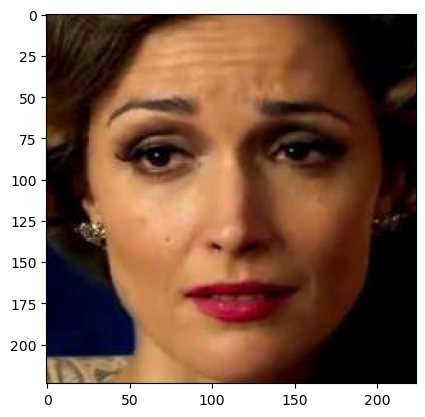

In [ ]:
val_Dataset2 = CustomImageDataset(val_img_names, val_img_dir, val_exp_annot, val_annot_dir)
img_idx = 10
img4val = val_Dataset2[img_idx][0]
annot4val = val_Dataset2[img_idx][1]
annot_file4val = val_Dataset2[img_idx][2]

# annotations list
emotions = ('neutral', 'happiness', 'sad', 'suprise', 'fear', 'disgust', 'anger', 'contempt')

# image
transform = T.ToPILImage()
img = transform(img4val)
plt.imshow(img)

# ground truth annotation
annot_true = annot4val
emotion_true = emotions[annot_true]
print(f"Ground Truth Emotion: {emotion_true}")

# predicted annotation
annot_pred = torch.argmax(model(img4val.type(torch.float).to(device))).item()
emotion_pred = emotions[annot_pred]
print(f"predicted Emotion: {emotion_pred}")

## LIVE Face Detection & Emotion Classification in Webcam

In [ ]:
# load model
model = EmotionClassifier()
model.load_state_dict(torch.load('current_best_model.pt'), strict=False)

face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
    ret, test_img = cap.read()  # captures frame and returns boolean value and captured image
    if not ret:
        continue
    
    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)

    for (x, y, w, h) in faces_detected:
        cv2.rectangle(test_img, (x, y), (x + w, y + h), (255, 0, 0), thickness=7)
        roi_gray = gray_img[y:y + w, x:x + h]  # cropping region of interest i.e. face area from  image
        roi_gray = cv2.resize(roi_gray, (224, 224))
        img_pixels = img_to_array(roi_gray)
        # img_pixels = np.expand_dims(img_pixels, axis=0)
        # img_pixels = np.squeeze(img_pixels)
        img_pixels = np.moveaxis(img_pixels, -1, 0) # reshaping from (224, 224, 3) --> (3, 224, 224) in a correct way

        prediction_scores = model(torch.tensor(img_pixels))
        print(prediction_scores)
        predictions = torch.argmax(prediction_scores)
        print(predictions)

        # find max indexed array
        max_index = predictions.numpy()

        emotions = ('neutral', 'happiness', 'sad', 'suprise', 'fear', 'disgust', 'anger', 'contempt')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ', resized_img)

    if cv2.waitKey(10) == ord('q'):  # wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows

## LIVE Face Detection & Emotion Classification in Screen Mirroring

In [ ]:
# load model
model = EmotionClassifier()
model.load_state_dict(torch.load('current_best_model.pt'), strict=False)

face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def process_img(image):
    original_image = image
    processed_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # processed_img =  cv2.Canny(processed_img, threshold1 = 200, threshold2=300)
    return processed_img

while True:
    screen = np.array(ImageGrab.grab(bbox=(0, 40, 1200, 1200))) # range of capture
    new_screen = process_img(screen)

    faces_detected = face_haar_cascade.detectMultiScale(new_screen, 1.32, 5)

    for (x, y, w, h) in faces_detected:
        cv2.rectangle(new_screen, (x, y), (x + w, y + h), (255, 0, 0), thickness=7)
        roi_gray = new_screen[y:y + w, x:x + h]  # cropping region of interest i.e. face area from  image
        roi_gray = cv2.resize(roi_gray, (224, 224))
        img_pixels = img_to_array(roi_gray)
        # img_pixels = np.expand_dims(img_pixels, axis=0)
        # img_pixels = np.squeeze(img_pixels)
        img_pixels = np.moveaxis(img_pixels, -1, 0) # reshaping from (224, 224, 3) --> (3, 224, 224) in a correct way

        prediction_scores = model(torch.tensor(img_pixels))
        print(prediction_scores)
        predictions = torch.argmax(prediction_scores)
        print(predictions)

        # find max indexed array
        max_index = predictions.numpy()

        emotions = ('neutral', 'happiness', 'sad', 'suprise', 'fear', 'disgust', 'anger', 'contempt')
        predicted_emotion = emotions[max_index]

        cv2.putText(new_screen, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    resized_img = cv2.resize(new_screen, (900, 900)) # window size
    cv2.imshow('Facial emotion analysis ', resized_img)

    if cv2.waitKey(10) == ord('q'):  # wait until 'q' key is pressed
        break

cv2.destroyAllWindows